In [1]:
import numpy as np
from keras.layers import Input, Dense, Conv1D, AvgPool1D, MaxPool1D, Flatten, UpSampling1D, Reshape, BatchNormalization, LSTM, Lambda, concatenate, TimeDistributed
from keras.models import Model
from keras import regularizers
from keras.utils import to_categorical, print_summary
from keras.callbacks import CSVLogger
from sklearn.cluster import KMeans
from datasources import LoadMachineMonitoringData
from matplotlib import pyplot as plt

n_clusters = 5
n_features = 100

Using TensorFlow backend.


In [2]:
train, test, validate, meta = LoadMachineMonitoringData()
x_min = train.min(axis=(0, 1))
x_max = train.max(axis=(0, 1))
for channel_idx in range(x_min.size):
    train[:, :, channel_idx] = (train[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    test[:, :, channel_idx] = (test[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    validate[:, :, channel_idx] = (validate[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])

In [3]:
kernel_l1 = 1e-4
kernel_l2 = 0
bias_l1 = 0
bias_l2 = 0
activation_l1 = 0
activation_l2 = 0

In [8]:
EncoderInputs = Input(shape=(train.shape[1], train.shape[2],))

RegularizerParams = {
    'kernel_regularizer': regularizers.l1_l2(kernel_l1, kernel_l2),
    'bias_regularizer': regularizers.l1_l2(bias_l1, bias_l2)
}

HiddenLayerParams = {
    'activation': 'relu',
    **RegularizerParams,
    'activity_regularizer': regularizers.l1_l2(activation_l1, activation_l2)
}

OutputLayerParams = {
    'activation': 'relu',
    **RegularizerParams
}

EncoderOutput = EncoderInputs
EncoderSlices = [None] * 6
for idx in range(6):
    EncoderSlices[idx] = Lambda(lambda x: x[:, 1000*idx:1000*(idx+1), :])(EncoderOutput)
    EncoderSlices[idx] = Reshape((1, 1000, 17))(EncoderSlices[idx])
EncoderOutput = concatenate(EncoderSlices, axis=1)
EncoderFeatureSlices = [None] * 17
for idx in range(17):
    EncoderFeatureSlices[idx] = Lambda(lambda x: x[:, :, :, idx])(EncoderOutput)
#     EncoderFeatureSlices[idx] = Reshape((6, 1000, 1))(EncoderFeatureSlices[idx])
    EncoderFeatureSlices[idx] = TimeDistributed(Dense(n_features, **HiddenLayerParams))(EncoderFeatureSlices[idx])
    print(EncoderFeatureSlices[idx].shape)
    EncoderFeatureSlices[idx] = Reshape((6, n_features, 1))(EncoderFeatureSlices[idx])
# EncoderOutput = TimeDistributed(LSTM(n_features, **HiddenLayerParams))(EncoderOutput)
EncoderOutput = concatenate(EncoderFeatureSlices, axis=-1)

EncoderModel = Model(inputs=EncoderInputs, outputs=EncoderOutput)
EncoderModel.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)
print_summary(EncoderModel)

# AutoEncoderOutput = Dense(EncoderModel.layers[-2].output_shape[1], **HiddenLayerParams)(EncoderOutput)
# AutoEncoderOutput = Reshape(EncoderModel.layers[-3].output_shape[1:3])(AutoEncoderOutput)
AutoEncoderOutput = EncoderOutput
AutoEncoderFeatureSlices = [None] * 17
AutoEncoderSlices = [None] * 6
for idx in range(17):
    AutoEncoderFeatureSlices[idx] = Lambda(lambda x: x[:, :, :, idx])(AutoEncoderOutput)
    print(AutoEncoderFeatureSlices[idx].shape)
#     AutoEncoderFeatureSlices[idx] = Reshape((6, n_features, 1))(AutoEncoderFeatureSlices[idx])
    AutoEncoderFeatureSlices[idx] = TimeDistributed(Dense(1000, **HiddenLayerParams))(AutoEncoderFeatureSlices[idx])
    AutoEncoderFeatureSlices[idx] = Reshape((6, 1000, 1))(AutoEncoderFeatureSlices[idx])
AutoEncoderOutput = concatenate(AutoEncoderFeatureSlices, axis=-1)
for idx in range(6):
    AutoEncoderSlices[idx] = Lambda(lambda x: x[:, idx, :, :])(AutoEncoderOutput)
AutoEncoderOutput = concatenate(AutoEncoderSlices, axis=1)

# AutoEncoderOutput = TimeDistributed(Dense(1000, **HiddenLayerParams))(AutoEncoderOutput)
# AutoEncoderOutput = Conv1D(17, (1,), **OutputLayerParams, padding='same')(AutoEncoderOutput)
    
AutoEncoderModel = Model(inputs=EncoderInputs, outputs=AutoEncoderOutput)
AutoEncoderModel.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)
print_summary(AutoEncoderModel)

(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 6000, 17)     0                                            
__________________________________________________________________________________________________
lambda_46 (Lambda)              (None, 1000, 17)     0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_47 (Lambda)              (None, 1000, 17)     0           input_5[0][0]                    
__________________________________________________________________________________________________
lamb

(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
(?, 6, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 6000, 17)     0                                            
__________________________________________________________________________________________________
lambda_46 (Lambda)              (None, 1000, 17)     0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_47 (Lambda)              (None, 1000, 17)     0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_48 (Lambda)          

In [9]:
ColOffset = (train.shape[1] - AutoEncoderModel.layers[-1].output_shape[1]) // 2
if ColOffset > 0:
    train_y = train[:, ColOffset:-ColOffset, :]
    test_y = test[:, ColOffset:-ColOffset, :]
    validate_y = validate[:, ColOffset:-ColOffset, :]
else:
    train_y = train
    test_y = test
    validate_y = validate
print(train_y.shape)
print(test_y.shape)
print(validate_y.shape)

(1239, 6000, 17)
(414, 6000, 17)
(552, 6000, 17)


In [10]:
log_file_name = 'example1.4_l1={:}_l2={:}_dense-act={:}_output-act={:}_features={:}_log.csv'.format(kernel_l1, kernel_l2, HiddenLayerParams['activation'], OutputLayerParams['activation'], n_features)
csv_logger = CSVLogger(log_file_name, append=False, separator=',')

In [11]:
AutoEncoderModel.fit(train, train_y, validation_data=(test, test_y), batch_size=64, epochs=50, callbacks=[csv_logger])

Train on 1239 samples, validate on 414 samples
Epoch 1/50
1239/1239 [==============================] - 7s 6ms/step - loss: 10.1497 - mean_squared_error: 0.1701 - val_loss: 7.1961 - val_mean_squared_error: 0.1416
Epoch 2/50
1239/1239 [==============================] - 2s 2ms/step - loss: 5.1827 - mean_squared_error: 0.1297 - val_loss: 3.1422 - val_mean_squared_error: 0.1181
Epoch 3/50
1239/1239 [==============================] - 2s 2ms/step - loss: 1.9503 - mean_squared_error: 0.1041 - val_loss: 0.8844 - val_mean_squared_error: 0.0851
Epoch 4/50
1239/1239 [==============================] - 2s 2ms/step - loss: 0.5164 - mean_squared_error: 0.0596 - val_loss: 0.3142 - val_mean_squared_error: 0.0303
Epoch 5/50
1239/1239 [==============================] - 2s 2ms/step - loss: 0.2335 - mean_squared_error: 0.0222 - val_loss: 0.1826 - val_mean_squared_error: 0.0196
Epoch 6/50
1239/1239 [==============================] - 2s 2ms/step - loss: 0.1642 - mean_squared_error: 0.0173 - val_loss: 0.1506 -

1239/1239 [==============================] - 2s 2ms/step - loss: 0.1143 - mean_squared_error: 0.0138 - val_loss: 0.1142 - val_mean_squared_error: 0.0143


In [12]:
pred_validation_y = AutoEncoderModel.predict(validate)
print('Validation MSE: {:}'.format(np.mean((validate_y - pred_validation_y) ** 2)))

data = np.vstack([train, test, validate])
enc_data = EncoderModel.predict(data)
print(enc_data.shape)

reconstructed_data = AutoEncoderModel.predict(data)
print(reconstructed_data.shape)

Validation MSE: 0.014031143859028816
(2205, 6, 100, 17)
(2205, 6000, 17)


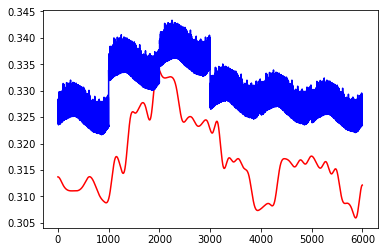

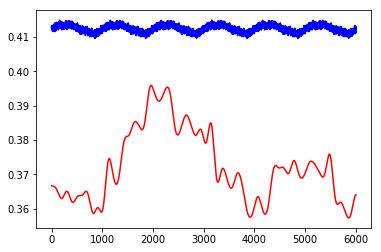

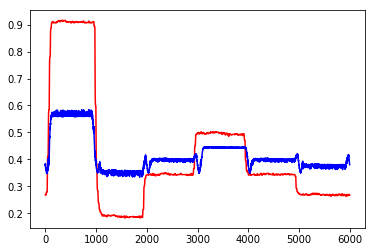

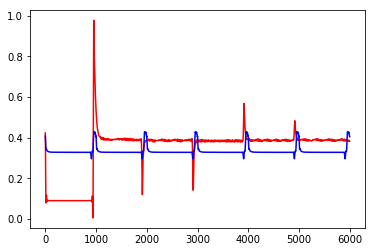

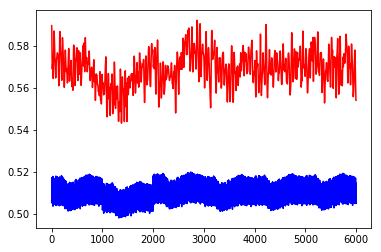

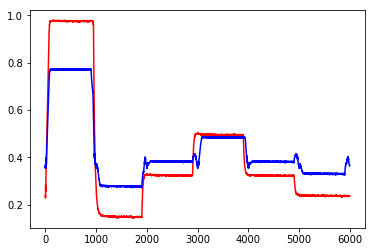

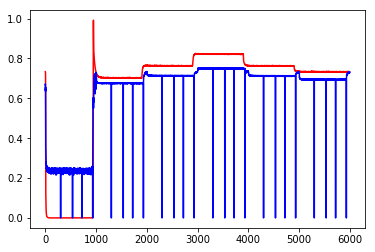

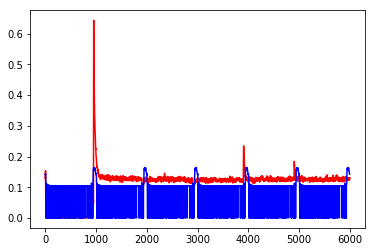

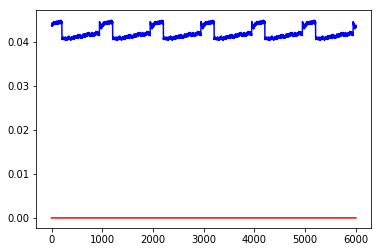

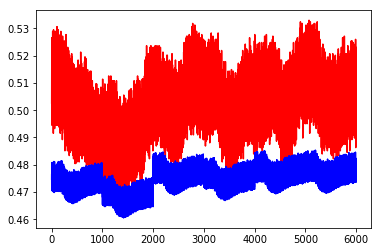

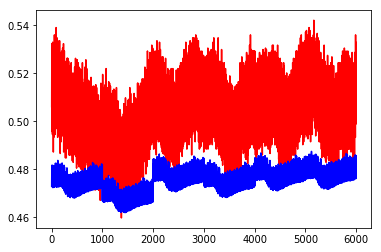

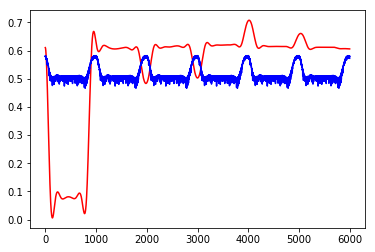

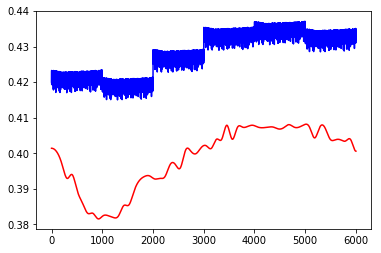

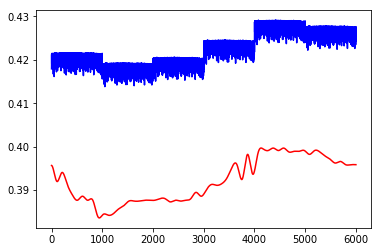

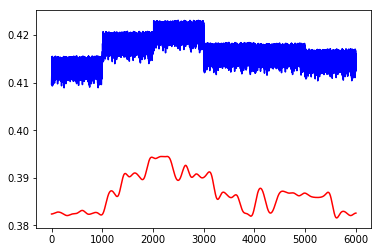

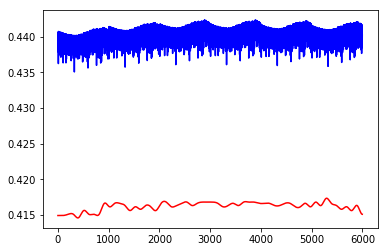

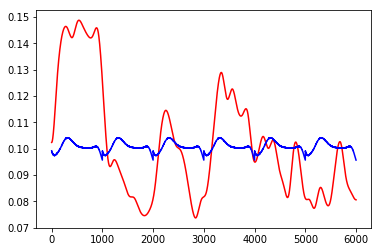

In [13]:
x_values = np.arange(data.shape[1])
x_values2 = np.arange(reconstructed_data.shape[1]) + (data.shape[1] - reconstructed_data.shape[1]) // 2
for idx in range(data.shape[2]):
    plt.figure()
    plt.plot(x_values, data[100, :, idx], 'r', x_values2, reconstructed_data[100, :, idx], 'b')
plt.show()